In [38]:
import numpy as np
import pandas as pd

# ログ表示
class Log:
    # 表示ログレベル
    Loglevel = 0
    def logLevelset(level):
        # 表示ログレベルの設定
        Log.Loglevel = level
    def log_print(level, std, *variable):
        if(Log.Loglevel >= level):
            if(len(variable) == 0):
                print(std)
            else:
                for i in range(len(variable)):
                    index = std.find("}") + 1
                    # 改行なし表示
                    print(std[:index].format(variable[i]), end='')
                    # 表示した分を削除
                    std = std.replace(std[:index], "", 1)
                # 改行表示
                print(std)

In [39]:
Log.logLevelset(0)

In [40]:
class ScratchDeepNeuralNetrowkRegressor:
    """
    シンプルな三層ニューラルネットワーク分類器

    Parameters
    ----------

    Attributes
    ----------
    """
    def __init__(self, verbose=True, lr=1e-4, num_epoch=100, batch_size=1460, sigma=1e-4, n_nodes1=10, n_nodes2=5, n_output=1):
        self.verbose = verbose
        self.lr = lr
        self.num_epoch = num_epoch # epoch回数
        self.batch_size = batch_size # バッチサイズ
        self.sigma = sigma
        self.n_features = 0
        self.n_nodes1 = n_nodes1 # 1層目のノード数
        self.n_nodes2 = n_nodes2 # 2層目のノード数
        self.n_output = n_output # 出力数（3層目のノード数）
        self.cost = []
        
        # レイヤーのインスタンス
        self.FC1 = None
        self.FC2 = None
        self.FC3 = None
        self.activation1 = None
        self.activation2 = None
        self.activation3 = None
    
    def fit(self, X, y, X_val=None, y_val=None):
        if self.verbose:
            #verboseをTrueにした際は学習過程などを出力する
            print()
        
        # array変換
        X = np.array(X)
        y = np.array(y)
        
        # ミニバッチ生成
        get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size)
                
        """
        初期化処理
        """
        self.n_features = X.shape[1]
        
        optimizer = SGD(self.lr)
        self.FC1 = FC(self.n_features, self.n_nodes1, HeInitializer(), optimizer)
        self.activation1 = ReLU()
        self.FC2 = FC(self.n_nodes1, self.n_nodes2, HeInitializer(), optimizer)
        self.activation2 = ReLU()
        self.FC3 = FC(self.n_nodes2, self.n_output, HeInitializer(), optimizer)
        self.activation3 = Identity()
        
        # エポック数分繰り返す
        for epoch in range(self.num_epoch):
            #print(epoch)
            for i, (mini_X, mini_y) in enumerate(get_mini_batch):
                """
                フォワードプロパゲーション
                """
                A1 = self.FC1.forward(X)
                Z1 = self.activation1.forward(A1)
                A2 = self.FC2.forward(Z1)
                Z2 = self.activation2.forward(A2)
                A3 = self.FC3.forward(Z2)
                Z3 = self.activation3.forward(A3)
                
                """
                フォワードプロパゲーション
                """
                dA3 = self.activation3.backward(Z3, y) # 交差エントロピー誤差とソフトマックスを合わせている
                dZ2 = self.FC3.backward(dA3)
                dA2 = self.activation2.backward(dZ2)
                dZ1 = self.FC2.backward(dA2)
                dA1 = self.activation1.backward(dZ1)
                dZ0 = self.FC1.backward(dA1) # dZ0は使用しない
                
            # 平均二乗誤差
            loss = MSE.calculation(dA3)
            self.cost.append(loss)
            
    def predict(self, X):
        # array変換
        X = np.array(X)
        
        get_mini_batch = GetMiniBatch(X, X, batch_size=10)
        
        for i, (mini_X, mini_y) in enumerate(get_mini_batch):
            A1 = self.FC1.forward(X)
            Z1 = self.activation1.forward(A1)
            A2 = self.FC2.forward(Z1)
            Z2 = self.activation2.forward(A2)
            A3 = self.FC3.forward(Z2)
            Z3 = self.activation3.forward(A3)
            
        return Z3

In [41]:
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = initializer.W(n_nodes1, n_nodes2)
        Log.log_print(1, "self.W.shape{}", self.W.shape)
        Log.log_print(2, "self.W{}", self.W)
        self.B = initializer.B(n_nodes2)
        Log.log_print(1, "self.B.shape{}", self.B.shape)
        Log.log_print(2, "self.B{}", self.B)   
        self.forward_x = 0
        self.dZ = 0
        self.dA = 0
        
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """
        self.forward_x = X.copy()
        Log.log_print(2, "self.forward_x{}", self.forward_x)
        Log.log_print(1, "self.forward_x.shape{}", self.forward_x.shape)
        A = np.dot(X, self.W) + self.B
        Log.log_print(1, "A.shape{}", A.shape)
        Log.log_print(2, "A{}", A)
        return A
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        Log.log_print(1, "更新前")
        Log.log_print(1, "self.B{}", self.B.shape)
        Log.log_print(1, "self.W{}", self.W.shape)
        
        self.dA = dA
        Log.log_print(1, "self.dA.shape{}", self.dA.shape)
        
        self.dZ = np.dot(dA, self.W.T)
        Log.log_print(1, "self.dZ.shape{}", self.dZ.shape)
        
        Log.log_print(2, "self.dZ{}", self.dZ)
        Log.log_print(1, "self.dZ.shape{}", self.dZ.shape)
        
        # 更新
        #self = self.optimizer.update(self)
        self.optimizer.update(self)
        
        Log.log_print(1, "更新後")
        Log.log_print(1, "self.B{}", self.B.shape)
        Log.log_print(1, "self.W{}", self.W.shape)
        
        return self.dZ

In [42]:
class SimpleInitializer:
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    function : std
      初期関数のモード
    """
    def __init__(self, sigma):
        self.sigma = sigma
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W :
        """
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :
        """
        B = self.sigma * np.random.randn(1, n_nodes2)
        return B

In [43]:
class HeInitializer:
    """
    He分布による初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    function : std
      初期関数のモード
    """
    def __init__(self):
        self.sigma = 0
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W :
        """
        self.sigma = np.sqrt(2 / n_nodes1)
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :
        """
        B = self.sigma * np.random.randn(1, n_nodes2)
        return B

In [54]:
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス

        Returns
        ----------
        layer : 更新後の層のインスタンス
        """
        layer.W = layer.W - self.lr*np.dot(layer.forward_x.T, layer.dA) / layer.dA.shape[0]
        layer.B = layer.B - self.lr*np.mean(layer.dA, axis=0)[np.newaxis,:]
        
        Log.log_print(1, "layer.W.shape{}", layer.W.shape)
        Log.log_print(2, "layer.W{}", layer.W)
        Log.log_print(1, "layer.B.shape{}", layer.B.shape)
        Log.log_print(2, "layer.B{}", layer.B)
        
        #return layer

In [55]:
class AddGrand:
    """
    最適劣勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
        
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス

        Returns
        ----------
        layer : 更新後の層のインスタンス
        """
        layer.HW = layer.HW + layer.W**2
        layer.HB = layer.HB + np.mean(layer.B**2, axis=0)[np.newaxis,:]
        
        layer.W = layer.W - self.lr*(1/np.sqrt(layer.HW))*np.dot(layer.forward_x.T, layer.dA) / layer.dA.shape[0]
        layer.B = layer.B - self.lr*(1/np.sqrt(layer.HB))*np.mean(layer.dA, axis=0)[np.newaxis,:]
        
        Log.log_print(1, "layer.W.shape{}", layer.W.shape)
        Log.log_print(2, "layer.W{}", layer.W)
        Log.log_print(1, "layer.B.shape{}", layer.B.shape)
        Log.log_print(2, "layer.B{}", layer.B)
        
        #return layer

In [46]:
class Tanh:
    def __init__(self):
        self.A = 0
        
    def forward(self, A):
        self.A = A
        return np.tanh(A)
    
    def backward(self, dZ):
        dA = dZ *(1 - np.tanh(self.A)**2)
        Log.log_print(1, "dA.shape{}", dA.shape)
        Log.log_print(2, "dA{}", dA)
        return dA

In [47]:
class ReLU:
    def __init__(self):
        self.A = 0
        
    def forward(self, A):
        self.A = A
        return np.maximum(A, 0)
    
    def backward(self, dZ):
        A = self.A.copy()
        A[A>0]=1
        A[A<=0]=0
        dA = dZ*A
        Log.log_print(1, "dA.shape{}", dA.shape)
        Log.log_print(2, "dA{}", dA)
        return dA

In [48]:
class Identity:
    def __init__(self):
        pass
    def forward(self, A):
        return A
    def backward(self, Yhat, Y):
        return Yhat - Y

In [49]:
class MSE:
    @classmethod
    def calculation(self, loss):
        return np.mean((loss)**2) / 2

In [50]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      学習データ
    y : 次の形のndarray, shape (n_samples, 1)または(n_samples,)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード

    Retruns
    ----------
    for文で呼び出すと以下の2つを返す。最後のイテレーションでは、バッチサイズより小さいこともある。
    mini_X : 次の形のndarray, shape (batch_size, n_features)
      学習データのミニバッチ
    mini_y : 次の形のndarray, shape (batch_size, 1)または(batch_size,)
      正解値のミニバッチ
    """
    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        # ランダムに並べ換える
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._counter = 0
        # イテレーション数を計算する
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        # len()が使われたときの処理
        return self._stop

    def __iter__(self):
        return self

    def __next__(self):
        # for文で呼ばれた際のループごとの処理
        if self._counter >= self._stop:
            # 最後まで進んだら終了
            self._counter = 0
            raise StopIteration()

        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]

In [51]:
data = pd.read_csv("./House_Prices/train.csv")
X = data[["GrLivArea", "YearBuilt"]]
y = data[["SalePrice"]]

In [77]:
NW = ScratchDeepNeuralNetrowkRegressor()

In [78]:
NW.fit(X, y)

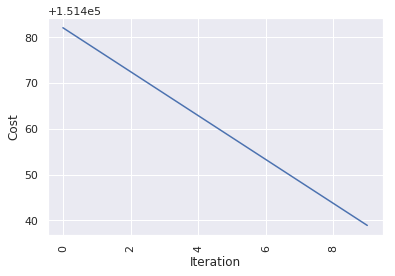

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

plt.plot(NW.cost)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.xticks(rotation="vertical")
plt.show()

In [80]:
NW.predict(X)

array([[-574.04929516],
       [-322.75400431],
       [-624.12698686],
       ...,
       [-935.33379398],
       [-238.71820837],
       [-321.44277895]])

In [56]:
NW2 = ScratchDeepNeuralNetrowkRegressor()

In [57]:
NW2.fit(X, y)

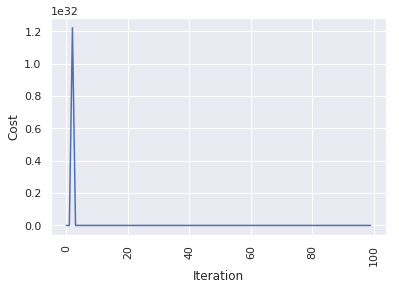

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

plt.plot(NW2.cost)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.xticks(rotation="vertical")
plt.show()

In [61]:
NW2.predict(X)

array([[-1.53451512e+12],
       [-1.53451512e+12],
       [-1.53451512e+12],
       ...,
       [-1.53451512e+12],
       [-1.53451512e+12],
       [-1.53451512e+12]])